#### **Import packages and modules**

In [16]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import correlate

from tqdm import tqdm

#### **View constants**

In [17]:
bit_step = 0.1 # s

frequency = 700  # 700 Hz
amplitude = 1  # Given amp of generated sine

phase_discritization = 100 # points to one period

#### **Read data from .wav file**

In [18]:
# Load data from wave file into numpy
sample_rate, signal = wavfile.read('File_09_p2_2023_105035.wav') # File_14_p2_2023.wav

# Changing data type for working properly
signal = signal.astype(np.float32)

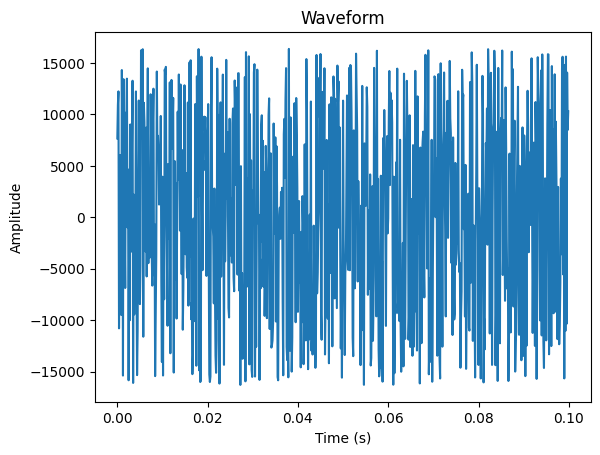

In [19]:
import matplotlib.pyplot as plt

# Get time axis
time_axis = np.arange(len(signal)) / float(sample_rate)

# Graph setting
plt.plot(time_axis[:800], signal[:800]) # get only some subsample of data 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

#### **Analyze signal using statistics**

In [20]:
# Getting wave duration 
duration = len(signal) / sample_rate

# Getting the length of voice file
print("Duration of audio file:", duration, "seconds")
print("The number of .wav points is", len(signal))

Duration of audio file: 84.8 seconds
The number of .wav points is 678400


#### **Break signal into batches with bit_step**

In [21]:
# Getting number of fragments
n_segments = int(np.ceil(len(signal) / (sample_rate * bit_step)))

# Dividing signal by fragments
signal_segments = np.array_split(signal, n_segments)

In [22]:
print(f"Amount of signal segments is: {len(signal_segments)}; And length of each segment is: {len(signal_segments[0])}")

Amount of signal segments is: 848; And length of each segment is: 800


#### **Checking phase bias for sinus**

In [23]:
# вычисление шага изменения сдвига фазы
phase_step = 2 * np.pi / phase_discritization

# вычисление корреляций для каждого сдвига фазы
correlations = np.zeros(phase_discritization)
for i, shift in tqdm(enumerate(np.arange(0, 2*np.pi, phase_step))):
    corr_sum = 0
    for segment in signal_segments:
        # сдвиг синусоиды на заданный угол
        time = np.linspace(0, bit_step, len(segment), endpoint=False)
        shifted_sinusoid = amplitude * np.sin(2*np.pi*frequency*time + shift)
        # вычисление корреляции сигнала и синусоиды
        corr = np.corrcoef(segment, shifted_sinusoid)[0, 1]
        # перевод корреляции в правильный диапазон (-1, 1)
        corr = np.clip(corr, -1, 1)
        corr_sum += corr
    # усреднение корреляций по всем сегментам
    correlations[i] = corr_sum / len(signal_segments)

# нахождение наилучшей корреляции и соответствующего сдвига фазы
best_shift_index = np.argmax(correlations)
best_shift = best_shift_index * phase_step
best_correlation = correlations[best_shift_index]

100it [00:07, 12.59it/s]


In [24]:
print(f"The best shift is: {best_shift:.2f} with index of: {best_shift_index} and value of corelation is: {best_correlation:.6f}")

The best shift is: 0.00 with index of: 0 and value of corelation is: 0.110625


#### **Generate given sinus**

In [25]:
# seneration of sine with given parameters
sine = amplitude * np.sin(2 * np.pi * frequency * time + best_shift* 2 * np.pi / phase_discritization)

#### **Classify signal into 0 and 1**

In [26]:
# вычисление корреляций для каждого батча
correlations = []
for batch in signal_segments:
    corr = np.corrcoef(batch, sine)[0, 1]
    correlations.append(corr)

# преобразование списка корреляций в массив
correlations = np.array(correlations)

In [27]:
correlations

array([ 2.04160772e-02,  2.49134562e-01, -6.14699560e-02, -3.20135962e-02,
        3.63587591e-02,  2.32688855e-02,  2.46427334e-01,  2.30101243e-01,
       -9.85626778e-03,  2.19865221e-01,  2.75907135e-01, -1.67744337e-02,
        2.66013317e-01,  2.09915645e-01,  2.67402273e-01,  2.49054388e-01,
       -4.12780972e-03,  2.27149324e-01,  3.08511114e-01, -5.97864751e-03,
       -1.51424681e-02,  1.91670664e-01,  1.41466649e-02, -2.09676824e-02,
       -7.35404978e-03,  2.00960681e-01,  2.36656334e-01,  4.43605154e-02,
        2.62073435e-01,  2.98478106e-02, -8.67271292e-02,  2.82316223e-01,
        4.70183821e-02,  2.30662784e-01,  1.83663439e-01, -5.23053620e-02,
        2.69475028e-01,  1.92896973e-01,  2.30709824e-01, -3.78165074e-03,
        2.07807367e-02,  2.56770586e-01,  2.16990382e-01, -5.99383564e-02,
        3.05932999e-02,  2.43110020e-01,  2.87026655e-01,  2.81075989e-01,
       -7.16292808e-02,  3.55260888e-02,  2.18076196e-01, -3.01865247e-02,
        1.48473829e-03,  

#### **Plot the distribution of probability data (to find border to classify)**

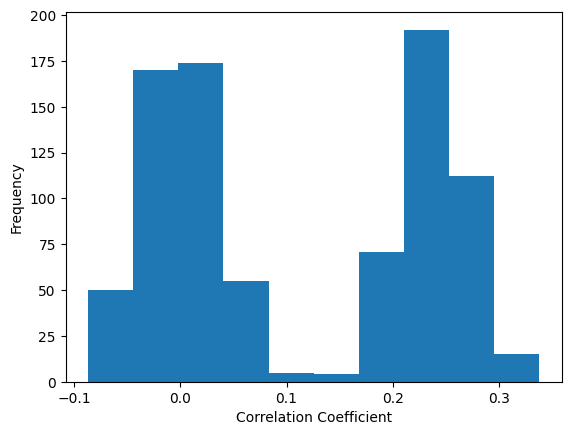

848

In [28]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(correlations)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()
len(correlations)

#### **Printing end message**

In [29]:
corr_dat = np.where(correlations > 0.14, 1, 0).astype(np.uint8)
pad_len = (8 - len(corr_dat) % 8) % 8  # number of bits to pad
print(pad_len)
corr_dat = np.pad(corr_dat, (0, pad_len), mode='constant')
decoded_ascii = ''
for i in range(0, len(corr_dat), 8):
    decoded_ascii += chr(int(''.join(map(str, corr_dat[i:i+8])), 2))
print("Decoded message:", decoded_ascii)

0
Decoded message: Coding standards: Ensure that the comments guide any readers through the algorithm and logic implelented.
